# Model Subsampling

## Based on OceanHackWeek21 project to subsample high-resolution model output as if by gliders, ships, or other *in situ* platforms

**Team:** <br>
Kyla Drushka <br>
Dhruv Balwada <br>
Iury Simoes-Sousa <br>
Diana LaScala-Gruenewald <br>
Cassia Cai

The goal of this project is to create a Python package that takes an input trajectory (e.g., the path of an ocean glider or a ship-based underway CTD), subsamples output from a high-resolution ocean simulation along that trajectory, and returns a set of subsampled variables (e.g., standard physical variables temperature, salinity, velocity; derived physical quantities such as steric height; biogeochemical quantities if available). We envision this package having two potential uses: 1) designing *in situ* sampling strategies, and 2) interpreting *in situ* data in the context of a highly resolved oceanographic model.

In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# define functions:
# great circle distance (from Jake Steinberg) (move this to the top?)
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))


### Import model data

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

(NOTE: make download_llc4320 a .py script called here!)


In [9]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify number of days to load
ndays = 3

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'




In [12]:
## Load all model data files  

# filenames:
ShortName = "MITgcm_LLC4320_Pre-SWOT_JPL_L4_" + RegionName + "_v1.0"
target_files = [f"{datadir}LLC4320_pre-SWOT_{RegionName}_201112{day}.nc" for day in range(21,21+3)] # list target files

ds = xr.open_mfdataset(target_files)


In [13]:
## Change time from datetime to integer to make life easier
# NOTE: might not want to do this ....
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size))

LLC4320 data does not have lat, lon as coordinates; instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory will have to be converted to the corresponding index numbers.

### NOTE: might not want to do this ... 

In [14]:
## Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)
i = ds.i
j = ds.j
z = ds.Z.isel(time=0)
k = ds.k

f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)
f_z = interpolate.interp1d(z, k, bounds_error=False)

In [92]:
# Get boundaries and center of model region
model_boundary_n = Y.max().values
model_boundary_s = Y.min().values
model_boundary_w = X.min().values
model_boundary_e = X.max().values
model_xav = ds.XC.isel(time=0, j=0).mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values


## Select sampling strategy

Use the `SAMPLING_STRATEGY` variable to select whether you want to sample the model using a real glider track ('real_glider'), a simulated glider track ('sim_glider') or a simulated underway ctd ('sim_uctd').

### note: could replace "real_glider" with any input file following some convention ... or add that capability e.g., a 4th open "trajectory_file"

In [15]:
## Set sampling strategy
SAMPLING_STRATEGY = 'sim_glider' 

### If you would like to subsample the model using a real glider track, set `SAMPLING_STRATEGY = 'real_glider'` and the following cells will be run.

Our example glider track original came from [this repo](https://github.com/earthcube2021/ec21_balwada_etal). It wasn't inside one of the regions covered by LLC4320. Here, we load the trajectory, transpose it such that it fits within the local model region, and covert lat, lon, and depth to indices i, j, and k.

In [79]:
## SAMPLING_STRATEGY == 'real_glider'; load, transpose, and convert glider data

if SAMPLING_STRATEGY == 'real_glider':

    # Load data
    ds_CTD_659 = xr.load_dataset('data/CTD_659.nc')

    # Transpose latitude
    shifted_lat = (ds_CTD_659.latitude - ds_CTD_659.latitude.min()
                  )/(ds_CTD_659.latitude.max() - ds_CTD_659.latitude.min()
                    )*(model_boundary_n-model_boundary_s)+ model_boundary_s


    # Transpose longitude
    shifted_lon = (ds_CTD_659.longitude - ds_CTD_659.longitude.min()
                  )/(ds_CTD_659.longitude.max() - ds_CTD_659.longitude.min()
                    )*(model_boundary_e-model_boundary_w)+ model_boundary_w

    # Remove NaN values from pressure (depth) data
    depth = -ds_CTD_659.pressure.where(~np.isnan(ds_CTD_659.pressure), drop=True)
    n = len(depth)

    # Assemble dataset
    survey_track = xr.Dataset(
        dict(
            lon = xr.DataArray(shifted_lon.where(~np.isnan(ds_CTD_659.pressure), drop=True),dims='points'),
            lat = xr.DataArray(shifted_lat.where(~np.isnan(ds_CTD_659.pressure), drop=True),dims='points'),
            dep = xr.DataArray(depth,dims='points'),
            time = xr.DataArray(np.linspace(ds.time[0], ds.time[-1]/24, num=n),dims='points') # convert time from # of hourly steps to days 
        )
    )
    
    # Transform to i,j,k coordinates:
    survey_indices= xr.Dataset(
        dict(
            i = xr.DataArray(f_x(survey_track.lon), dims='points'),
            j = xr.DataArray(f_y(survey_track.lat), dims='points'),
            k = xr.DataArray(f_z(survey_track.dep), dims='points'),
            time = xr.DataArray(survey_track.time,dims='points')
        )
    )

### If you would like to subsample the model using a simulated glider or ship-based uCTD track, set `SAMPLING_STRATEGY = 'sim_glider'` or `'sim_uctd'` and the following cells will be run.

This code is originally from `make_trajectory.ipynb`.

In [128]:
## SAMPLING_STRATEGY == 'sim_glider' or 'sim_uctd'; load, transpose, and convert simulated data

if SAMPLING_STRATEGY == 'sim_glider' or SAMPLING_STRATEGY == 'sim_uctd':

    # --------- define sampling: change the values in this section -------
    PATTERN = 'back-forth' # back-forth or lawnmower ... could add others
    survey_time_total = ndays * 86400 # if non-zero, limits the survey to a total time
    

    # typical speeds and depth ranges based on platform 
    if SAMPLING_STRATEGY == 'sim_uctd':
        # typical values for uctd sampling:
        zrange = [-5, -500] # depth range of profiles (down is negative)
        hspeed = 5 # platform horizontal speed in m/s
        vspeed = 1 # platform vertical (profile) speed in m/s (NOTE: may want different up/down speeds)
    elif SAMPLING_STRATEGY == 'sim_glider':
        # typical values for glider sampling:
        zrange = [-1, -1000] # depth range of profiles (down is negative)
        hspeed = 0.25 # platform horizontal speed in m/s
        vspeed = 0.25 # platform vertical (profile) speed in m/s  (NOTE: is this typical?)

    # define x & y waypoints and z range
    # - these are for the ACC_SMST region specifically ... could make generic based on the lat/lon of the domain
    # xwaypoints & ywaypoints must have the same size
    if PATTERN == 'lawnmower':
        # "mow the lawn" pattern - define all waypoints
        # generalize the survey for this region
        xwaypoints = model_boundary_w + 1 + [0, 0, 0.5, 0.5, 1, 1, 1.5, 1.5, 2, 2]
        ywaypoints = model_boundary_s + [1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2]
    elif PATTERN == 'back-forth':
        # repeated back & forth transects - define the end-points
        xwaypoints = model_xav + [-1, 1]
        ywaypoints = model_yav + [-1, 1]
        # repeat waypoints based on # of transects: 
        dkm_per_transect = great_circle(xwaypoints[0], ywaypoints[0], xwaypoints[1], ywaypoints[1]) # distance of one transect in km
        t_per_transect = dkm_per_transect * 1000 / hspeed # time per transect, seconds
        num_transects = np.round(survey_time_total / t_per_transect)
        for n in np.arange(num_transects):
            xwaypoints = np.append(xwaypoints, xwaypoints[-2])
            ywaypoints = np.append(ywaypoints, ywaypoints[-2])

    # time resolution of sampling (dt):
    # use the time between vertical measurements
    # for now, use a constant  vertical resolution (can change this later)
    zresolution = 10 # meters
    zprofile = np.arange(zrange[0],zrange[1],-zresolution) # depths for one profile
    ztwoway = np.append(zprofile,zprofile[-1:0:-1])

    dt = zresolution / vspeed # sampling resolution in seconds
    # for each timestep dt 
    deltah = hspeed*dt # horizontal distance traveled per sample
    deltav = vspeed*dt # vertical distance traveled per sample

    # determine the sampling locations in 2-d space
    # - initialize sample locations xs, ys, zs, ts
    xs = []
    ys = []
    zs = []
    ts = []
    dkm_total = 0 
    
    for w in np.arange(len(xwaypoints)-1):
        # interpolate between this and the following waypoint:
        dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
        # number of time steps (vertical measurements) between this and the next waypoint
        nstep = int(dkm*1000 / deltah) 
        yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
        xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
        xi = xi[0:-1] # remove last point, which is the next waypoint
        xs = np.append(xs, xi) # append
        yi = yi[0:-1] # remove last point, which is the next waypoint
        ys = np.append(ys, yi) # append
        dkm_total = dkm_total + dkm
        t_total = dkm_total * 1000 / hspeed
        # cut off the survey after survey_time_total, if specified
        if survey_time_total > 0 and t_total > survey_time_total:
            break

    # depths: repeat (tile) the two-way sampling depths (NOTE: for UCTD sampling, often only use down-cast data)
    # how many profiles do we make during the survey?
    n_profiles = np.ceil(xs.size / ztwoway.size)
    zs = np.tile(ztwoway, int(n_profiles))
    zs = zs[0:xs.size]
    # sample times: (units are in seconds since zero => convert to days, to agree with ds.time)
    ts = dt * np.arange(xs.size) / 86400 
    
    # get rid of points with sample time > survey_time_total
    if survey_time_total > 0:
        idx = np.abs(ts*86400 - survey_time_total).argmin() # index of ts closest to survey_time_total
        xs = xs[:idx]
        ys = ys[:idx]
        ts = ts[:idx]
        zs = zs[:idx]
        
    ## Assemble dataset:
    # real (lat/lon) coordinates
    survey_track = xr.Dataset(
        dict(
            lon = xr.DataArray(xs,dims='points'),
            lat = xr.DataArray(ys,dims='points'),
            dep = xr.DataArray(zs,dims='points'),
            time = xr.DataArray(ts,dims='points')
        )
    )
    # transform to i,j,k coordinates:
    survey_indices= xr.Dataset(
        dict(
            i = xr.DataArray(f_x(survey_track.lon), dims='points'),
            j = xr.DataArray(f_y(survey_track.lat), dims='points'),
            k = xr.DataArray(f_z(survey_track.dep), dims='points'),
            time = xr.DataArray(survey_track.time,dims='points'),
        )
    )

In [129]:
## Visualize trajectory

%matplotlib qt
# %matplotlib inline
    
nptime = survey_track.time.data
nplat = survey_track.lat.data
npdep = survey_track.dep.data
nplon = survey_track.lon.data

traj = np.array(list(zip(nplon, nplat, npdep)))

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(nplon, nplat, npdep, c=nptime, s=0.75)
fig.colorbar(p)
ax.set_title('survey track colored by time')

Text(0.5, 0.92, 'survey track colored by time')

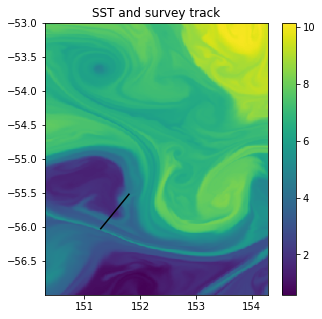

In [152]:
## Visualize track over model snapshot:
%matplotlib inline
plt.figure(figsize=(5,5))
plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
plt.plot(xs, ys, c='k')
plt.title('SST and survey track')
plt.colorbar()
plt.show()


## Perform the interpolation

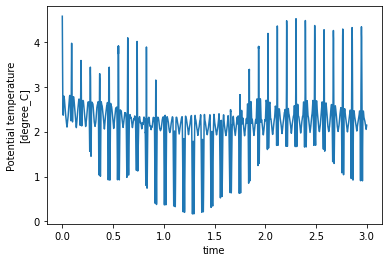

In [148]:
## Create a new dataset to contain the interpolated data and interpolate

%matplotlib inline

subsampled_data = xr.Dataset() # NOTE: add more metadata to this dataset?
subsampled_data['Theta']=ds.Theta.interp(survey_indices) # NOTE: is there a smarter way to do this using variable names and a loop?
subsampled_data['Salt']=ds.Theta.interp(survey_indices) 
subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time
subsampled_data

# Test plot
subsampled_data.Theta.plot(x='time') 
plt.show()

In [149]:
## Visualize

%matplotlib qt

if SAMPLING_STRATEGY == 'real_glider':

    # Downsample to speed up plotting/improve lagging
    nptime = subsampled_data.time.data[0:-1:10]
    nplat = subsampled_data.lat.data[0:-1:10]
    npdep = subsampled_data.dep.data[0:-1:10]
    nplon = subsampled_data.lon.data[0:-1:10]
    nptemp = subsampled_data.Theta.data[0:-1:10]

    ## Plot trajectory
    traj = np.array(list(zip(nplon, nplat, npdep)))

    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection='3d')
    fig.subplots_adjust(left=0.25, bottom=0.25)

    ax.set_xlabel('longitude', fontsize=15, rotation=150)
    ax.set_ylabel('latitude',fontsize=15)
    ax.set_zlabel('depth', fontsize=15, rotation=60)

    p = ax.scatter3D(nplon, nplat, npdep, c=nptemp, s=0.75)
    fig.colorbar(p)

    plt.show()

if SAMPLING_STRATEGY == 'sim_glider' or SAMPLING_STRATEGY == 'sim_uctd':
    
    nptime = subsampled_data.time.data
    nplat = subsampled_data.lat.data
    npdep = subsampled_data.dep.data
    nplon = subsampled_data.lon.data
    nptemp = subsampled_data.Theta.data

    traj = np.array(list(zip(nplon, nplat, npdep)))

    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection='3d')
    fig.subplots_adjust(left=0.25, bottom=0.25)

    ax.set_xlabel('longitude', fontsize=15, rotation=150)
    ax.set_ylabel('latitude',fontsize=15)
    ax.set_zlabel('depth', fontsize=15, rotation=60)

    p = ax.scatter3D(nplon, nplat, npdep, c=nptemp, s=0.75)
    fig.colorbar(p)

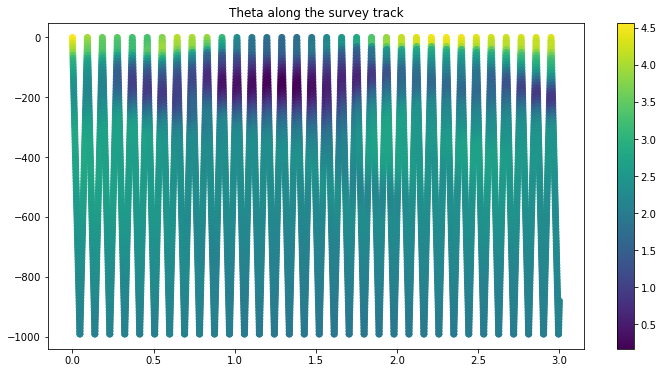

In [154]:
## Visualize a section as a function of time
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
plt.scatter(survey_track.time, survey_track.dep, c=subsampled_data.Theta.data)
plt.title('Theta along the survey track')
plt.colorbar()

### Interpolate variables that are not on the i-j grid, but shifted. 

Roughly based on: https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html

In [156]:
## Get u, v, vorticity

# Build grid
grid = Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                 'Y':{'center': 'j', 'left': 'j_g'},
                 'Z':{'center': 'k'}})

# Interpolate U and V from i_g, j_g to i, j 
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')

# Compute vorticity and interpolate to i,j
Vort = (grid.diff(ds.V*ds.DXG, 'X') - grid.diff(ds.U*ds.DYG, 'Y'))/ds.RAZ
Vort = grid.interp(grid.interp(Vort, 'X', boundary='extend'), 'Y', boundary='extend')

**NOTE** that there is a little boundary problem in the calculation, but can be dealt with if wanted. 

In [158]:
## Interpolate and add to subsampled_data

subsampled_data['U'] = U_c.interp(survey_indices)
subsampled_data['V'] = V_c.interp(survey_indices)
subsampled_data['Vort'] = Vort.interp(survey_indices)

In [159]:
%matplotlib qt

if SAMPLING_STRATEGY == 'real_glider':

    # Downsample to speed up plotting/improve lagging
    nptime = subsampled_data.time.data[0:-1:10]
    nplat = subsampled_data.lat.data[0:-1:10]
    npdep = subsampled_data.dep.data[0:-1:10]
    nplon = subsampled_data.lon.data[0:-1:10]
    npu = subsampled_data.U.data[0:-1:10]

elif SAMPLING_STRATEGY == 'sim_glider' or SAMPLING_STRATEGY == 'sim_uctd':
    
    nptime = subsampled_data.time.data
    nplat = subsampled_data.lat.data
    npdep = subsampled_data.dep.data
    nplon = subsampled_data.lon.data
    npu = subsampled_data.U.data
    
## Plot trajectory
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(nplon, nplat, npdep, c=npu, s=0.75)
fig.colorbar(p)

plt.show()
